In [324]:
%matplotlib inline
%pylab inline
import sympy as sym
import pylab as pl
import numpy as np
import numpy.polynomial.polynomial as n_poly
import numpy.polynomial.legendre as leg

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Equispaced and Chebishev

In [325]:
l_infty = lambda y: abs(y).max()

def lagrangian_interpolation_matrix(x,q):
    Ln = np.zeros((len(q), len(x)))
    for i in range(len(q)):
        Ln[i] = np.product([(x-q[j])/(q[i]-q[j]) for j in range(len(q)) if j != i], axis=0)
    return Ln

def der(f,n):
    assert len(f.free_symbols) == 1, "I can only do this for single variable functions..."
    t = f.free_symbols.pop()
    return sym.lambdify(t, f.diff(t, n), 'numpy')

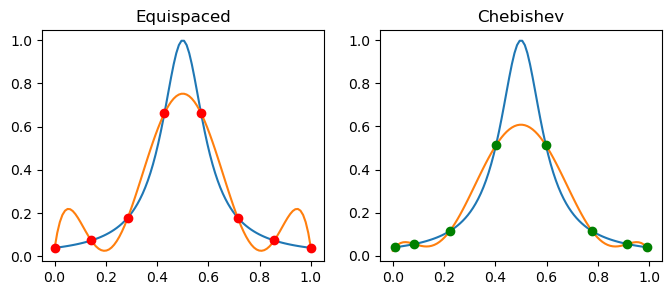

In [326]:
# Now construct a symbolic function...
t = sym.var('t')
fs = 1 / (1 + 100 * (t - 0.5)**2) # Runge function
fs_prime = fs.diff(t, 1)
f_prime = sym.lambdify(t,fs_prime, 'numpy')

f = der(fs,0)

n = 7
x = np.linspace(0,1,100)
q = np.linspace(0,1,n+1)

#Equispaced points
Ln = lagrangian_interpolation_matrix(x,q)

fig, axes = pl.subplots(1, 2, figsize=(8,3))
      
axes[0].plot(x, f(x))
axes[0].plot(x, Ln.T.dot(f(q)))
axes[0].plot(q, f(q), 'ro')
axes[0].set_title("Equispaced")


# Chebyshev points
x = np.linspace(0,1,100)
generator = lambda x,n: x.min()+(x.max()-x.min())/2*(np.polynomial.chebyshev.chebgauss(n)[0]+1)
# interpolation points
q1 = generator(x,n+1)

# The interpolation matrix
Lnc = lagrangian_interpolation_matrix(x,q1)

axes[1].plot(x, f(x))
axes[1].plot(x, Lnc.T.dot(f(q1)))
axes[1].plot(q1, f(q1), 'go')
axes[1].set_title("Chebishev");

show()

### Solving M Matrix

In [327]:
def define_lagrange_basis_set(q):
    n = q.shape[0]
    L = [n_poly.Polynomial.fromroots([xj for xj in q if xj != q[i]]) for i in range(n)]
    L = [L[i]/L[i](q[i]) for i in range(n)]
    return L

deg = 7
x = np.linspace(0,1,100)
q = np.linspace(0,1,deg+1)
Nq = deg+1

p,w = leg.leggauss(Nq)
w = .5 * w
p = .5*(p+1)

W = np.diag(w)

L = define_lagrange_basis_set(q)

# L = Ln

B = np.zeros((0,Nq))
for l in L:
    B = np.vstack([B,l(p)])
    
M = B.dot(W.dot(B.T))


# g = lambda x: sin(x**2)

f = der(fs,0)
p = p.reshape((p.shape[0],1))
func = f(p)

G = B.dot(W.dot(func))

u = np.linalg.solve(M, G)

def get_interpolating_function(LL,ui):
    def func(LL,ui,x):
        acc = 0
        for L,u in zip(LL,ui):
            #print(L,u)
            acc+=u*L(x)
        return acc
    return lambda x : func(LL,ui,x)

I = get_interpolating_function(L,u)

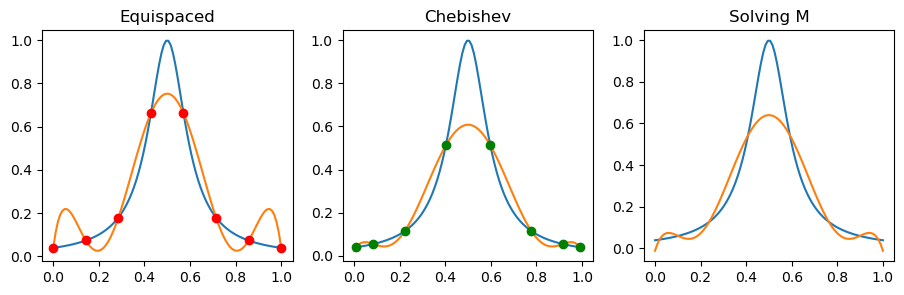

In [328]:

x = linspace(0,1,100)

fig, axes = pl.subplots(1, 3, figsize=(11,3))

axes[0].plot(x, f(x))
axes[0].plot(x, Ln.T.dot(f(q)))
axes[0].plot(q, f(q), 'ro')
axes[0].set_title("Equispaced")

axes[1].plot(x, f(x))
axes[1].plot(x, Lnc.T.dot(f(q1)))
axes[1].plot(q1, f(q1), 'go')
axes[1].set_title("Chebishev");

axes[2].plot(x, f(x))
axes[2].plot(x, I(x))
# axes[2].plot(q, u, 'mo')
axes[2].set_title("Solving M");

show()